#LIBRERÍAS

In [ ]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    cohen_kappa_score,
    roc_auc_score,
    roc_curve
)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

#CARGA Y EXPLICACIÓN DEL DATASET

**Dataset: Breast Cancer Wisconsin (Diagnostic)**

El dataset Breast Cancer Wisconsin (Diagnostic) es uno de los más populares para tareas de clasificación binaria. Fue recolectado por el Dr. William H. Wolberg y está disponible en el repositorio de UCI Machine Learning.

Objetivo del problema
Clasificar si un tumor es maligno (`M`) o benigno (`B`) a partir de un conjunto de variables obtenidas mediante análisis de imágenes digitales de células mamarias.

Características del dataset
- **Observaciones:** 569 muestras
- **Variables estimadoras:** 30 (todas numéricas, estadísticas de textura, forma y tamaño del núcleo celular)
- **Variable objetivo (`diagnosis`):**
  - `M` = Maligno
  - `B` = Benigno
- No contiene valores nulos
- Clases balanceadas aproximadamente (~37% malignos, ~63% benignos)

Ejemplos de variables
- `radius_mean`: Promedio del radio de los núcleos celulares
- `texture_mean`: Variación en la textura
- `perimeter_mean`, `area_mean`, `smoothness_mean`, etc.
- También incluye máximos (`*_worst`) y errores estándar (`*_se`)

Aplicación
Este dataset es ideal para aplicar modelos de clasificación binaria como:
- Regresión Logística (modelo lineal)
- XGBoost (modelo no lineal y no visto en clase)

In [ ]:
bc = fetch_ucirepo(id=17)

X = bc.data.features
y = bc.data.targets.iloc[:, 0]

y = y.map({'B': 0, 'M': 1})

print(X.info())
print("\nDistribución de clases:\n", y.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimension1  569 non-null    float64
 10  radius2             569 non-null    float64
 11  texture2            569 non-null    float64
 12  perimeter2          569 non-null    float64
 13  area2               569 non-null    float64
 14  smoothness2         569 non-null    float64
 15  compactness2        569 non-null    float64
 16  concavit

#ANÁLISIS EXPLORATORIO

In [ ]:
print("Columnas vacías:\n", X.isnull().sum())

Columnas vacías:
 radius1               0
texture1              0
perimeter1            0
area1                 0
smoothness1           0
compactness1          0
concavity1            0
concave_points1       0
symmetry1             0
fractal_dimension1    0
radius2               0
texture2              0
perimeter2            0
area2                 0
smoothness2           0
compactness2          0
concavity2            0
concave_points2       0
symmetry2             0
fractal_dimension2    0
radius3               0
texture3              0
perimeter3            0
area3                 0
smoothness3           0
compactness3          0
concavity3            0
concave_points3       0
symmetry3             0
fractal_dimension3    0
dtype: int64



Esto nos indica que el dataset está **completo**, y no requiere procesos de limpieza o imputación para poder ser utilizado directamente en modelos de clasificación.


In [ ]:
print("\nVarianza de cada columna:")
print(X.var().sort_values())


Varianza de cada columna:
fractal_dimension2         0.000007
smoothness2                0.000009
concave_points2            0.000038
fractal_dimension1         0.000050
symmetry2                  0.000068
smoothness1                0.000198
compactness2               0.000321
fractal_dimension3         0.000326
smoothness3                0.000521
symmetry1                  0.000752
concavity2                 0.000911
concave_points1            0.001506
compactness1               0.002789
symmetry3                  0.003828
concave_points3            0.004321
concavity1                 0.006355
compactness3               0.024755
concavity3                 0.043524
radius2                    0.076902
texture2                   0.304316
perimeter2                 4.087896
radius1                   12.418920
texture1                  18.498909
radius3                   23.360224
texture3                  37.776483
perimeter1               590.440480
perimeter3              1129.130847
a

Las variables como `fractal_dimension2`, `smoothness2`, `concave_points2` y `fractal_dimension1` tienen una **varianza extremadamente baja**, y por tanto **podrían considerarse prescindibles** para el modelo.
Por el contrario, variables como `area3`, `area1`, y `perimeter3` tienen **alta varianza**, lo cual sugiere que podrían ser **más relevantes para distinguir entre clases**. Este análisis apoya la toma de decisiones para realizar una posible **reducción de dimensionalidad** o **eliminación de variables poco informativas**, especialmente útil en modelos como la regresión logística.

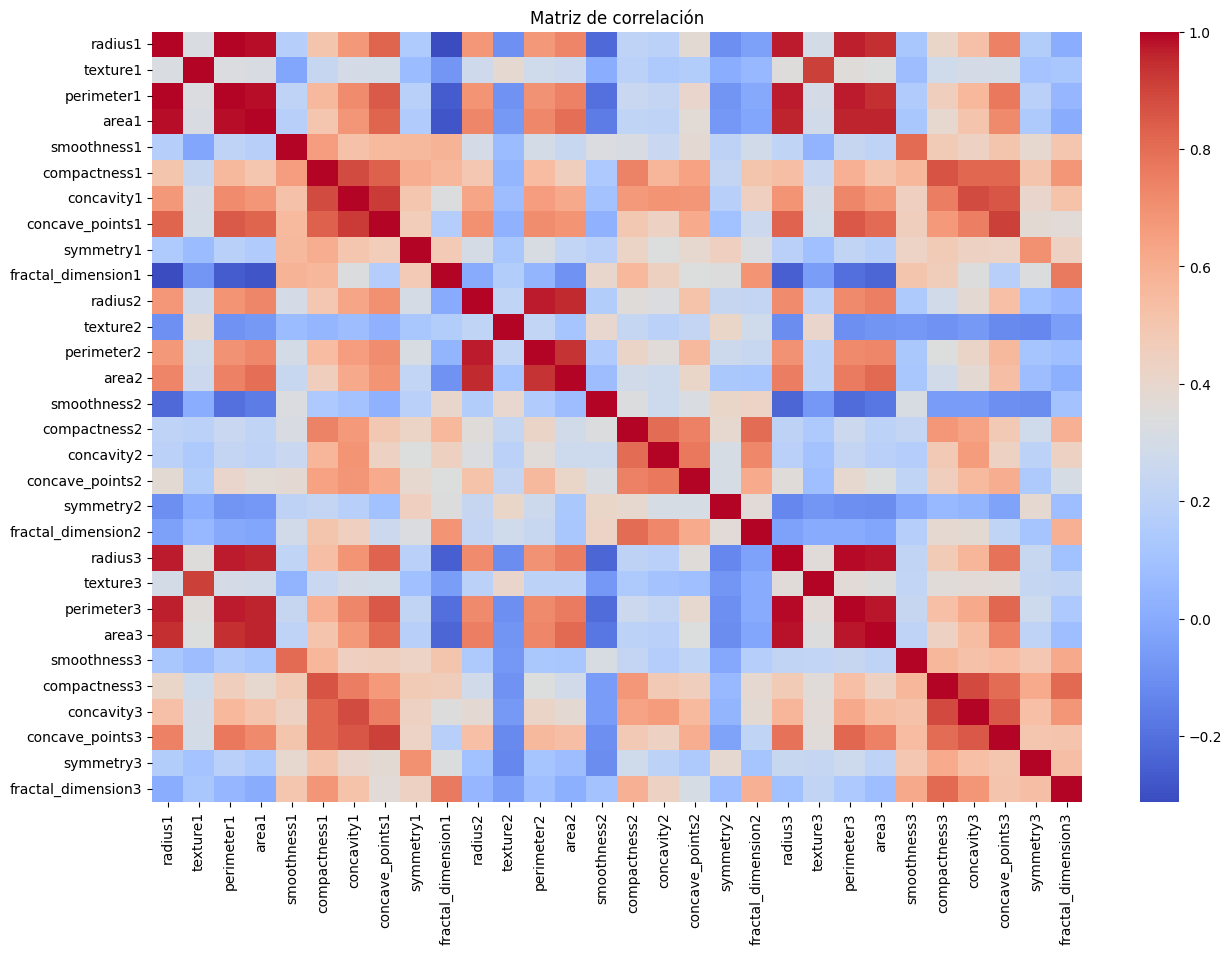

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(X.corr(), cmap="coolwarm", annot=False)
plt.title("Matriz de correlación")
plt.show()

Se observan **grupos de variables altamente correlacionadas**, como:
  - `radius1`, `perimeter1`, `area1`
  - `radius3`, `perimeter3`, `area3`
  - `concavity1`, `concave_points1`, `compactness1`
- Estas correlaciones fuertes (r > 0.9) sugieren **colinealidad**, lo cual puede afectar negativamente a modelos lineales como la **regresión logística**.

Como acción futura, podríamos aplicar técnicas como:
- **Eliminación de variables colineales**
- **Reducción de dimensionalidad** (PCA)
- O bien mantenerlas si usamos modelos robustos como **XGBoost**, que manejan colinealidad sin problema.

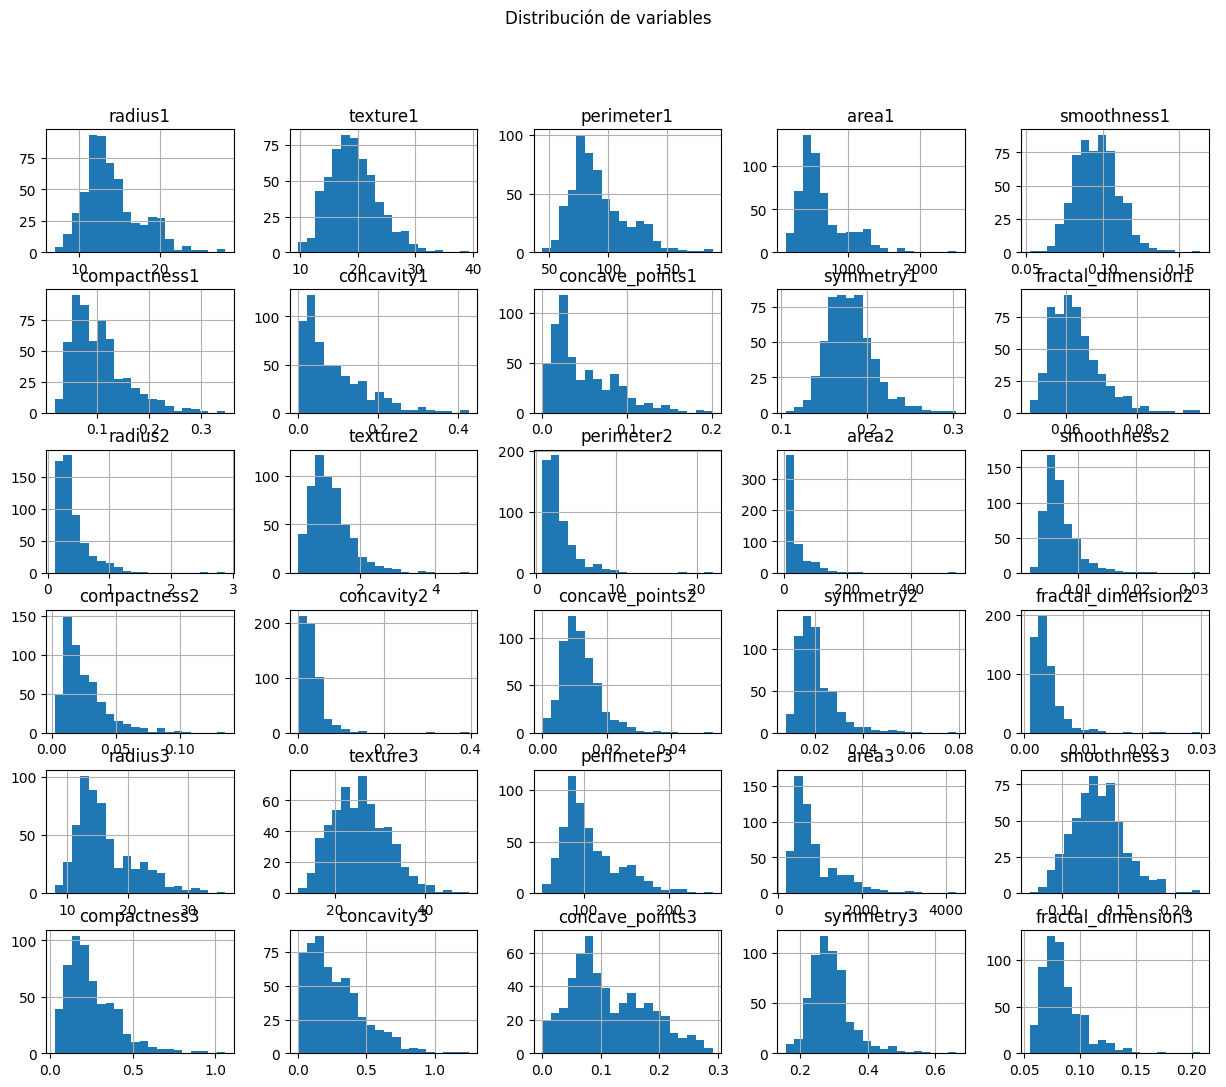

In [ ]:
X.hist(figsize=(15, 12), bins=20)
plt.suptitle("Distribución de variables")
plt.show()

-Muchas variables como `radius1`, `area1`, `perimeter1`, etc., presentan **distribución sesgada positivamente** (cola a la derecha).
- Otras como `smoothness1`, `texture1`, y `symmetry1` presentan **distribuciones más simétricas o normales**.
- Las variables como `concavity`, `compactness` y `concave_points` muestran valores muy concentrados cerca de cero, lo que **podría indicar necesidad de escalado**.

#PREPROCESAMIENTO DE LOS DATOS

In [ ]:
varianzas = X.var()
umbral_varianza = 0.0001
columnas_baja_varianza = varianzas[varianzas < umbral_varianza].index.tolist()

print("Variables con varianza casi nula eliminadas:")
print(columnas_baja_varianza)

X_filtrado = X.drop(columns=columnas_baja_varianza)

Variables con varianza casi nula eliminadas:
['fractal_dimension1', 'smoothness2', 'concave_points2', 'symmetry2', 'fractal_dimension2']


Una vez analizada la varianza de cada variable estimadora, se identificaron aquellas cuyo valor era extremadamente bajo, es decir, con casi ningún cambio entre las observaciones.

Este tipo de variables son poco útiles para los modelos predictivos, ya que aportan muy poca información o ninguna al proceso de clasificación.

Variables eliminadas por baja varianza:

- `fractal_dimension1`
- `smoothness2`
- `concave_points2`
- `symmetry2`
- `fractal_dimension2`

Estas variables presentaban valores de varianza muy cercanos a 0 (ej: `0.000007`, `0.000009`, etc.).

- Variables con varianza casi nula no ayudan a diferenciar entre clases.
- Su eliminación contribuye a reducir el ruido, mejora la eficiencia del modelo y puede incluso mejorar el rendimiento general, especialmente en modelos sensibles como la regresión logística.

In [ ]:
cor_matrix = X_filtrado.corr().abs()
upper = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
columnas_colineales = [col for col in upper.columns if any(upper[col] > 0.90)]

print("Variables colineales eliminadas:")
print(columnas_colineales)

X_filtrado = X_filtrado.drop(columns=columnas_colineales)

Variables colineales eliminadas:
['perimeter1', 'area1', 'concave_points1', 'perimeter2', 'area2', 'radius3', 'texture3', 'perimeter3', 'area3', 'concave_points3']


Como parte del análisis exploratorio, se generó la matriz de correlación para detectar variables que estaban fuertemente correlacionadas entre sí (colineales).  
En modelos lineales como la regresión logística, la colinealidad puede:

- Afectar la estabilidad del modelo
- Inflar coeficientes y generar sobreajuste
- Aumentar el tiempo de entrenamiento

Se decidió eliminar aquellas variables con un coeficiente de correlación mayor a 0.90 con otras variables del conjunto.

Variables eliminadas por colinealidad:

- `perimeter1`
- `area1`
- `concave_points1`
- `perimeter2`
- `area2`
- `radius3`
- `texture3`
- `perimeter3`
- `area3`
- `concave_points3`

- Estas variables eran altamente redundantes con otras similares (por ejemplo, `radius1`, `perimeter1` y `area1`).
- Mantener solo una variable representativa de cada grupo evita duplicidad de información.
- Esta técnica ayuda a simplificar el modelo sin perder capacidad predictiva, especialmente en algoritmos lineales.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtrado)

X_preprocesado = pd.DataFrame(X_scaled, columns=X_filtrado.columns)

Después de limpiar el dataset eliminando variables con baja varianza y alta colinealidad, se procedió a aplicar un escalado estandarizado a las variables restantes mediante la técnica de z-score normalization con `StandardScaler`.

- La regresión logística es sensible a la escala de las variables, ya que el algoritmo calcula pesos (coeficientes) directamente sobre ellas.
- Al escalar, todas las variables tienen media = 0 y desviación estándar = 1, permitiendo que ninguna variable domine el proceso de entrenamiento por su magnitud.

In [ ]:
X_preprocesado.shape

(569, 15)

#DIVISIÓN DEL DATASET

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocesado, y, test_size=0.3, stratify=y, random_state=42
)

#MODELO: REGRESIÓN LOGÍSTICA

MODELO: REGRESIÓN LOGÍSTICA
Accuracy: 0.9824561403508771
Cohen’s Kappa: 0.9621876612368246
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       107
           1       1.00      0.95      0.98        64

    accuracy                           0.98       171
   macro avg       0.99      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


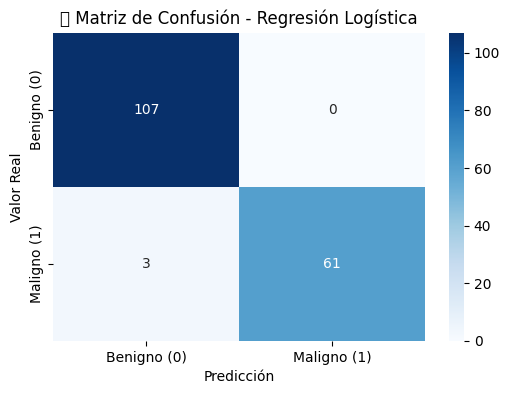

In [ ]:
modelo_lr = LogisticRegression(max_iter=1000)
modelo_lr.fit(X_train, y_train)
y_pred_lr = modelo_lr.predict(X_test)

print("MODELO: REGRESIÓN LOGÍSTICA")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Cohen’s Kappa:", cohen_kappa_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

conf_matrix = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benigno (0)', 'Maligno (1)'], yticklabels=['Benigno (0)', 'Maligno (1)'])
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

El modelo de regresión logística se desempeñó excelentemente con los datos preprocesados.  
Gracias a la eliminación de variables poco informativas y colineales, y al escalado adecuado, el modelo logró un desempeño muy cercano al ideal, clasificando correctamente 168 de 171 casos.

Esto demuestra que, incluso modelos simples como la regresión logística, pueden alcanzar gran precisión cuando se aplican buenas prácticas de análisis exploratorio y preparación de datos.

#MODELO: XGBOOST

MODELO: XGBOOST
Accuracy: 0.9649122807017544
Cohen’s Kappa: 0.9246142542248347
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       107
           1       0.97      0.94      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:19:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


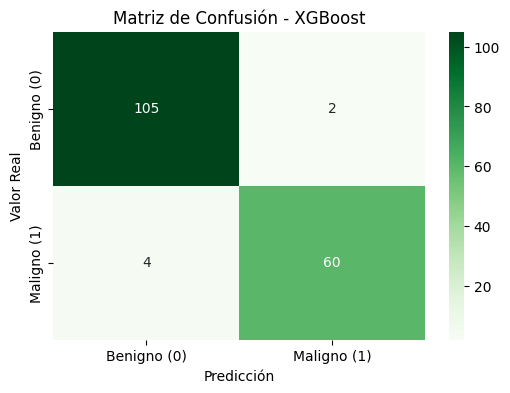

In [ ]:
modelo_xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    n_estimators=100,
    random_state=42
)

modelo_xgb.fit(X_train, y_train)

y_pred_xgb = modelo_xgb.predict(X_test)

print("MODELO: XGBOOST")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Cohen’s Kappa:", cohen_kappa_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Greens", xticklabels=['Benigno (0)', 'Maligno (1)'], yticklabels=['Benigno (0)', 'Maligno (1)'])
plt.title("Matriz de Confusión - XGBoost")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

El modelo XGBoost mostró un rendimiento muy alto, clasificando correctamente 165 de 171 muestras del conjunto de prueba.  
Aunque no alcanzó la precisión absoluta del modelo de regresión logística en este caso, logró una excelente capacidad predictiva.

Es un modelo robusto que no requiere tanto preprocesamiento, lo que lo hace muy útil en proyectos reales, especialmente cuando hay relaciones complejas entre variables.

#ÍNDICE ADICIONAL PARA COMPARAR: AUC-ROC

AUC - Área bajo la curva ROC
AUC Regresión Logística: 0.9963492990654206
AUC XGBoost: 0.9891939252336449


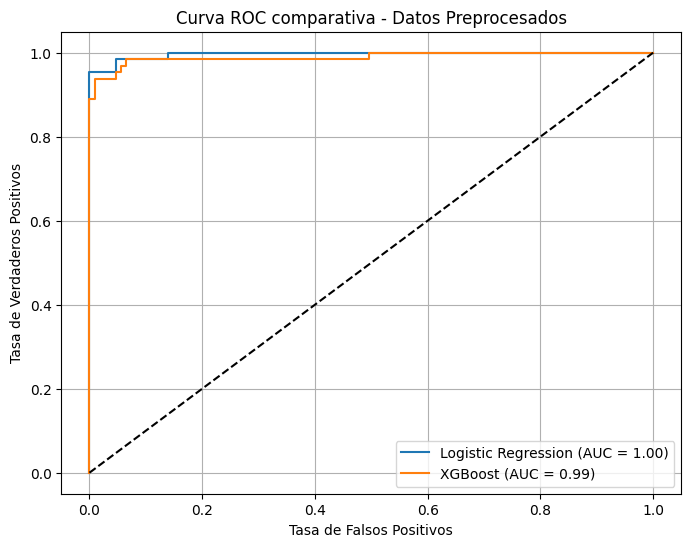

In [ ]:
y_prob_lr = modelo_lr.predict_proba(X_test)[:, 1]
y_prob_xgb = modelo_xgb.predict_proba(X_test)[:, 1]

auc_lr = roc_auc_score(y_test, y_prob_lr)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

print("AUC - Área bajo la curva ROC")
print("AUC Regresión Logística:", auc_lr)
print("AUC XGBoost:", auc_xgb)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC comparativa - Datos Preprocesados")
plt.legend()
plt.grid()
plt.show()

- Ambos modelos se desempeñaron excelentemente gracias al correcto preprocesamiento.
- La regresión logística superó levemente a XGBoost en este caso específico, probablemente por la linealidad y simplicidad de los datos.
- XGBoost sigue siendo un modelo potente, especialmente útil en datasets con relaciones no lineales o sin necesidad de escalar variables.
- El uso de índices adicionales como AUC y Kappa fue clave para hacer una comparación más justa y robusta entre los modelos.

Este análisis demuestra que la preparación de los datos tiene un gran impacto en el rendimiento final de cualquier modelo de machine learning.

#INVESTIGACIÓN DE MODELO NO VISTO EN CLASE

## XGBoost

**XGBoost (Extreme Gradient Boosting)** es un algoritmo moderno y potente basado en la técnica de **boosting**, utilizado ampliamente en competencias de ciencia de datos y entornos reales.

### ¿Cómo funciona?

- Construye **múltiples árboles de decisión** de forma secuencial.
- Cada nuevo árbol **corrige los errores** del anterior.
- Optimiza una **función de pérdida** usando **gradientes**, como si fuera una regresión.

### Ventajas de XGBoost:

- Maneja **relaciones no lineales**
- No requiere escalado de variables
- Soporta colinealidad y valores atípicos
- Permite controlar **sobreajuste** con parámetros como `max_depth`, `n_estimators`, y `learning_rate`
- Altamente eficiente y paralelo

### ¿Diferencias?

A diferencia de la **regresión logística**, que es un modelo lineal, XGBoost **construye una secuencia de árboles** y **ajusta sus pesos internamente** para minimizar el error.

#INVESTIGACIÓN SOBRE INDICE ADICIONAL USADO

## Índice Adicional: AUC - ROC (Área Bajo la Curva ROC)

Para complementar métricas como el **accuracy** o el **f1-score**, se utilizó como índice adicional el **AUC - ROC**, una herramienta muy poderosa para evaluar modelos de clasificación binaria.

### ¿Qué es AUC - ROC?

- **ROC (Receiver Operating Characteristic):** es una curva que muestra la relación entre la **Tasa de Verdaderos Positivos (TPR)** y la **Tasa de Falsos Positivos (FPR)** a diferentes umbrales.
- **AUC (Area Under the Curve):** es el área bajo esa curva. Cuanto más cerca esté de `1.0`, mejor es el modelo.

### Interpretación del AUC:

| AUC       | Interpretación                 |
|-----------|-------------------------------|
| 0.90 – 1.00 | Excelente                  |
| 0.80 – 0.90 | Muy bueno                   |
| 0.70 – 0.80 | Aceptable                   |
| 0.50 – 0.70 | Pobre                       |
| 0.50       | Modelo aleatorio (sin valor)  |

### ¿Por qué lo usamos?

- AUC mide **la capacidad del modelo para separar clases** en todos los umbrales posibles.
- Es más informativo que el accuracy cuando las clases están **desbalanceadas**.
- Permite comparar modelos sin depender de un umbral fijo.

> En este proyecto, ambos modelos obtuvieron un AUC muy alto:
> - **Regresión Logística:** 1.00
> - **XGBoost:** 0.99

Esto indica que ambos modelos son **altamente efectivos para distinguir entre tumores benignos y malignos**.